<a href="https://colab.research.google.com/github/ViktNi/Interior2/blob/main/Pod_AutoKeras(2_3_7).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AutoKeras

Входные данные: TRN_33.zip, img_size=(64, 64).
Результаты:
*   после пятой итерации:
Best val_accuracy So Far: 0.8833333253860474
Total elapsed time: 02h 05m 22s


---



In [ ]:
#
# Входные данные: train-архив (например, TRN_42.zip) (включает в себя подкаталоги-классы изображений
# для обучения и валидации) и test-архив (ПОКА НЕ ИСПОЛЬЗУЕТСЯ) (например, TST_42.zip) (подкаталоги-классы для финального
# тестирования), заданные прямыми ссылками на файл Google Disk'а
# типа "https://drive.google.com/uc?export=download&confirm=no_antivirus&id=1EHvO9KWB6EDtjkNcCmfQtlZ7x17SADcb"
#

In [ ]:
# Ссылка на загружаемый файл берется не отсюда, а из load_dataset().

# Задаем необходимые параметры
dbg=True  # Полный (True) или стандартный (краткий) вывод информации
# dbg=False  # Полный (True) или стандартный (краткий) вывод информации
zip_trn_nm='TRN_33.zip' # Имя датасета для обучения и валидации (подкаталоги-классы)
# zip_tst_nm='TST_33.zip' # Имя финального тестового датасета (подкаталоги-классы)
trn_https="https://drive.google.com/uc?export=download&confirm=no_antivirus&id=1R2zbT9FN4vPyDx4dTjjmUhf9fMpoSrM7" # TRN_33.zip
# tst_https="https://drive.google.com/uc?export=download&confirm=no_antivirus&id=1EHvO9KWB6EDtjkNcCmfQtlZ7x17SADcb"
# zip_trn_nm='TRN_42.zip' # Имя датасета для обучения и валидации (подкаталоги-классы)
# zip_tst_nm='TST_42.zip' # Имя финального тестового датасета (подкаталоги-классы)
# trn_https="https://drive.google.com/uc?export=download&confirm=no_antivirus&id=16fxSTOQo5B2sKudWf_8uX3EwCw6Lafps"
# tst_https="https://drive.google.com/uc?export=download&confirm=no_antivirus&id=1GZTo2nGCuAc5Zs3EOVjLzCqtgt1OyB6V"


In [ ]:
#@title Подключение библиотек

!pip -q install autokeras
import autokeras as ak

# Подключение нужных слоев из модуля tensorflow.keras.layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Dropout, GlobalMaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay # Матрица ошибок классификатора
from PIL import Image # Отрисовка изображений
from sklearn.model_selection import train_test_split # Разделение на обучающую и проверочную/тестовую выборку

import numpy as np # Библиотека работы с массивами
import matplotlib.pyplot as plt # Отрисовка графиков
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline

import os # Для работы с файлами
import random # Генерация случайных чисел
import gdown # Подключение модуля для загрузки данных из облака
import gc

from IPython.display import clear_output          # clear_output(wait=True)

import warnings                    # Управление предупреждениями
warnings.filterwarnings("ignore")

import tensorflow as tf
tf.get_logger().setLevel('ERROR')
tf.get_logger().setLevel('ERROR')

class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

class Worker:
  def __init__(self):
    self.IMAGE_PATH = '/content/data/'
    self.CLASS_LIST = None
    self.CLASS_COUNT = None

  def load_dataset(self):
    # arch_name = gdown.download('https://storage.yandexcloud.net/aiueducation/marketing/23.03/construction.zip', None, quiet=True)
    # arch_name = gdown.download("https://drive.google.com/uc?export=download&confirm=no_antivirus&id=1R2zbT9FN4vPyDx4dTjjmUhf9fMpoSrM7", None, quiet=True) # TRN_33.zip
    arch_name = gdown.download(trn_https, None, quiet=True) # TRN_33.zip
    # Разархивация датасета в директорию '/content'
    !unzip -qo {arch_name} -d /content/data
    self.CLASS_LIST = sorted(os.listdir(self.IMAGE_PATH))
    self.CLASS_COUNT = len(self.CLASS_LIST)
    print(f'Датасет загружен!\n')
    print(f'Количество классов: {self.CLASS_COUNT}')
    res = "\n  * ".join(self.CLASS_LIST)
    print(f'Метки классов:\n  * {res}')

  def show_samples(self, count = 3):
    n_rows = count
    # Создание заготовки для изображений всех классов
    fig, axs = plt.subplots(n_rows, self.CLASS_COUNT, figsize=(35, 5*n_rows-5))

    # Для всех номеров классов:
    for i in range(self.CLASS_COUNT):
      for j in range(n_rows):
        # Формирование пути к папке содержимого класса
        car_path = f'{self.IMAGE_PATH}{self.CLASS_LIST[i]}/'
        # Выбор случайного фото из i-го класса
        img_path = car_path + random.choice(os.listdir(car_path))
        # Отображение фотографии (подробнее будет объяснено далее)
        axs[j][i].set_title(self.CLASS_LIST[i])
        axs[j][i].imshow(Image.open(img_path))
        axs[j][i].axis('off')
    # Отрисовка всего полотна
    plt.show()

  def dataset_info(self):
    self.data_files = []                           # Cписок путей к файлам картинок
    self.data_labels = []                          # Список меток классов, соответствующих файлам
    cnt_files = []                            # Количество файлов каждого класса

    for class_label in range(self.CLASS_COUNT):    # Для всех классов по порядку номеров (их меток)
        class_name = self.CLASS_LIST[class_label]  # Выборка имени класса из списка имен
        class_path = self.IMAGE_PATH + class_name  # Формирование полного пути к папке с изображениями класса
        class_files = os.listdir(class_path)  # Получение списка имен файлов с изображениями текущего класса
        cnt_files.append(len(class_files))
        print(f'Размер класса {class_name} составляет {len(class_files)}')
        # Добавление к общему списку всех файлов класса с добавлением родительского пути
        self.data_files += [f'{class_path}/{file_name}' for file_name in class_files]

        # Добавление к общему списку меток текущего класса - их ровно столько, сколько файлов в классе
        self.data_labels += [class_label] * len(class_files)

    print('\nОбщий размер базы для обучения:', len(self.data_labels))
    plt.figure(figsize=(25, 8))
    plt.bar(self.CLASS_LIST, cnt_files)
    plt.show()



  def create_sets(self, size=(64, 64)):

    # import cv2  # Только для сохранения ч-б изображения как цветного, ни к чему.

    IMG_WIDTH = size[0]                            # Ширина изображения
    IMG_HEIGHT = size[1]                           # Высота изображения
    data_images = []                               # Пустой список для данных изображений

    for file_name in self.data_files:
        # Открытие и смена размера изображения
        img = Image.open(file_name).resize((IMG_WIDTH, IMG_HEIGHT))
        # Конвертация изображений в режиме CMYK в режим RGB
        if img.mode == 'CMYK':
          img = img.convert('RGB')

        img_np = np.array(img)                # Перевод в numpy-массив
        # print(img_np.shape)# Вывод на экран для визуальной проверки размерности
        # if img_np.shape==(224,224): # Если изображение одноканальное, т.е. черно-белое
          # print(file_name)
        if img_np.shape==(IMG_WIDTH,IMG_HEIGHT): # Если изображение одноканальное, т.е. черно-белое,
          # то его нужно преобразовать в цветное.
          # Создание трехканального цветного изображения
          color_image = np.stack((img_np,) * 3, axis=-1)

          # Преобразование массива в формат uint8 (8-бит беззнаковый целочисленный тип)
          color_image = color_image.astype(np.uint8)
          img_np = np.array(color_image)
          # # Сохранение цветного изображения, если надо
          # cv2.imwrite('цветное_изображение.jpg', color_image)
        data_images.append(img_np)            # Добавление изображения в виде numpy-массива к общему списку

    data_images = np.array(data_images) # Теперь data_images имеет размерность (К-во изображений,224,224,3)
    x_data = np.array(data_images)            # Перевод общего списка изображений в numpy-массив
    y_data = np.array(self.data_labels)            # Перевод общего списка меток класса в numpy-массив

    # Нормированние массива изображений
    x_data = x_data / 255.
    x_train, x_test, y_train, y_test = train_test_split(x_data, # набор параметров
                                                    y_data, # набор меток классов
                                                    test_size=0.2, # процент в тестовую
                                                    shuffle=True, #  перемешивание
                                                    random_state=3) # воспроизводимость
    print(f'Размер обучающей выборки: {x_train.shape}')
    print(f'Размер проверочной выборки: {x_test.shape}')
    self.sets = (x_train, x_test, y_train, y_test)
    gc.collect()
    return x_train, x_test, y_train, y_test

  def ShowConfusionMatrix(self, model, x_test, y_test):
    cm = confusion_matrix(y_test,
                          np.argmax(model.predict(x_test, verbose=0), axis=1),
                          normalize = 'true')

    # Отрисовка матрицы ошибок
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_title(f'матрица ошибок', fontsize=18)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=self.CLASS_LIST)
    disp.plot(ax=ax)
    plt.gca().images[-1].colorbar.remove()  # Стирание ненужной цветовой шкалы
    plt.xlabel('Предсказанные классы', fontsize=16)
    plt.ylabel('Верные классы', fontsize=16)
    plt.grid(False)
    fig.autofmt_xdate(rotation=45)          # Наклон меток горизонтальной оси при необходимости
    plt.show()

  def show_learning_information(self, history, model):
    print('График обучения:')
    # Создание полотна для рисунка
    plt.figure(1, figsize=(10, 6))

    # Отрисовка графиков 'accuracy' и 'val_accuracy' из значений словаря store_learning.history
    plt.plot(history.history['accuracy'],
            label='Доля верных ответов на обучающем наборе')
    plt.plot(history.history['val_accuracy'],
            label='Доля верных ответов на проверочном наборе')
    # Задание подписей осей
    plt.xlabel('Эпоха обучения')
    plt.ylabel('Доля верных ответов')
    plt.legend()
    # Фиксация графиков и рисование всей картинки
    plt.show()
    print(f'Максимальная точность на обучающей выборке: {round(np.array(history.history["accuracy"]).max(), 3)}')
    print(f'Максимальная точность на проверочной выборке: {round(np.array(history.history["val_accuracy"]).max(), 3)}')

    print('\nМатрица ошибок для обучающей выборки:')
    self.ShowConfusionMatrix(model, self.sets[0], self.sets[2])
    print('\nМатрица ошибок для проверочной выборки:')
    self.ShowConfusionMatrix(model, self.sets[1], self.sets[3])

  def train_model(self, funcModel, count):
    # Обучение модели сверточной нейронной сети подготовленных данных
    cnt = count
    history_accuracy = []
    history_val_accuracy = []
    for i in range(cnt):
      model = funcModel()
      store_learning = model.fit(x_train,
                                y_train,
                                validation_data=(x_test, y_test),
                                shuffle=True,
                                batch_size=25,
                                epochs=50,
                                verbose=0)
      history_accuracy.append(store_learning.history['accuracy'])
      history_val_accuracy.append(store_learning.history['val_accuracy'])
      print(f'{bcolors.BOLD}{bcolors.OKBLUE}Обучение №{i+1} завершено. Результаты{bcolors.ENDC}')
      print(f'Максимальная точность на обучающей выборке: {round(np.array(store_learning.history["accuracy"]).max(), 3)}')
      print(f'Максимальная точность на проверочной выборке: {round(np.array(store_learning.history["val_accuracy"]).max(), 3)}')
      print('\n'*3)
    print(f'{bcolors.BOLD}###############################################################################{bcolors.ENDC}')
    print(f'{bcolors.HEADER} Финальные результаты{bcolors.ENDC}')
    print(f'Средняя точность на обучающей выборке: {round(np.array(history_accuracy).max(axis=1).mean(), 3)}')
    print(f'Максимальная точность на обучающей выборке: {round(np.array(history_accuracy).max(), 3)}')
    print(f'Средняя точность на проверочной выборке: {round(np.array(history_val_accuracy).max(axis=1).mean(), 3)}')
    print(f'Максимальная точность на проверочной выборке: {round(np.array(history_val_accuracy).max(), 3)}')

# Определение EarlyStopping-коллбека
# Форма регуляризации, используемая для избежания переобучения
es_callback = EarlyStopping(monitor='val_loss', patience=4)

# Коллбек для отслеживания изменений в метриках и визуализации их на графиках
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs2")

worker=Worker()
# clear_output()  # output() ВЫДАЕТ СООБЩЕНИЕ ОБОШИБКЕ, НО, ВИДИМО, НЕ КРИТИЧНОЕ

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.6/148.6 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 573.5/573.5 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 924.6/924.6 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 92.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 104.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 26.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pydantic 2.2.1 requires typing-extensions>=4.6.1, but you have typing-extensions 4.5.0 which is incom

In [ ]:
# Загрузка датасета
worker.load_dataset()

Датасет загружен!

Количество классов: 33
Метки классов:
  * Electrical Works - Ceiling fan
  * Electrical Works - Electrical panel
  * Electrical Works - Lamp
  * Electrical Works - Light fixture
  * Electrical Works - Socket
  * Electrical Works - Switch
  * Electrical Works - Wiring
  * Flooring - Carpet
  * Flooring - Linoleum
  * Flooring - Liquid screed
  * Flooring - Vinyl flooring
  * Painting - Ceiling
  * Painting - Decorative painting
  * Painting - Decorative plaster
  * Painting - Door
  * Painting - Molding
  * Painting - Wall
  * Painting - Wallpaper
  * Painting - Window
  * Painting - Window trim
  * Plumbing Works - - Water heater
  * Plumbing Works - Bathtub
  * Plumbing Works - Drainage system
  * Plumbing Works - Faucet
  * Plumbing Works - Pipes
  * Plumbing Works - Shower cabin
  * Plumbing Works - Sink
  * Plumbing Works - Siphon
  * Plumbing Works - Tap
  * Plumbing Works - Toilet
  * Tiling - Kitchen backsplash tile
  * Tiling - Mosaic
  * Tiling - Tile


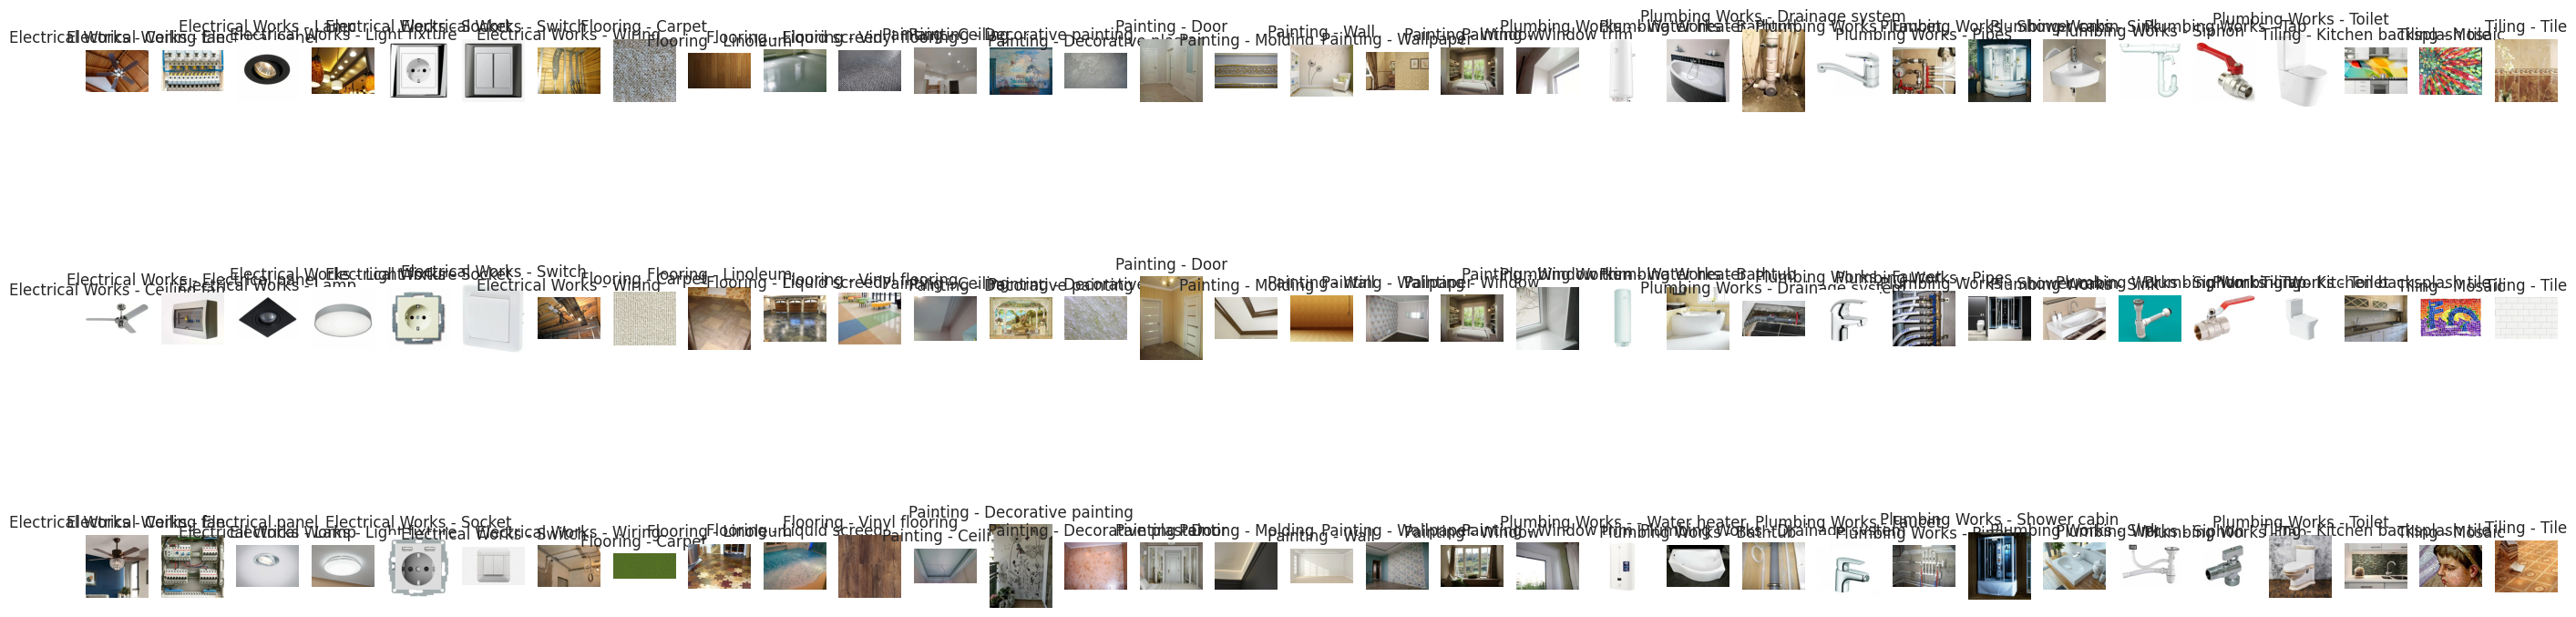

In [ ]:
# Вывод примеров
worker.show_samples()

Размер класса Electrical Works - Ceiling fan составляет 100
Размер класса Electrical Works - Electrical panel составляет 100
Размер класса Electrical Works - Lamp составляет 100
Размер класса Electrical Works - Light fixture составляет 100
Размер класса Electrical Works - Socket составляет 100
Размер класса Electrical Works - Switch составляет 100
Размер класса Electrical Works - Wiring составляет 100
Размер класса Flooring - Carpet составляет 100
Размер класса Flooring - Linoleum составляет 100
Размер класса Flooring - Liquid screed составляет 100
Размер класса Flooring - Vinyl flooring составляет 100
Размер класса Painting - Ceiling составляет 100
Размер класса Painting - Decorative painting составляет 100
Размер класса Painting - Decorative plaster составляет 100
Размер класса Painting - Door составляет 100
Размер класса Painting - Molding составляет 100
Размер класса Painting - Wall составляет 100
Размер класса Painting - Wallpaper составляет 100
Размер класса Painting - Window сос

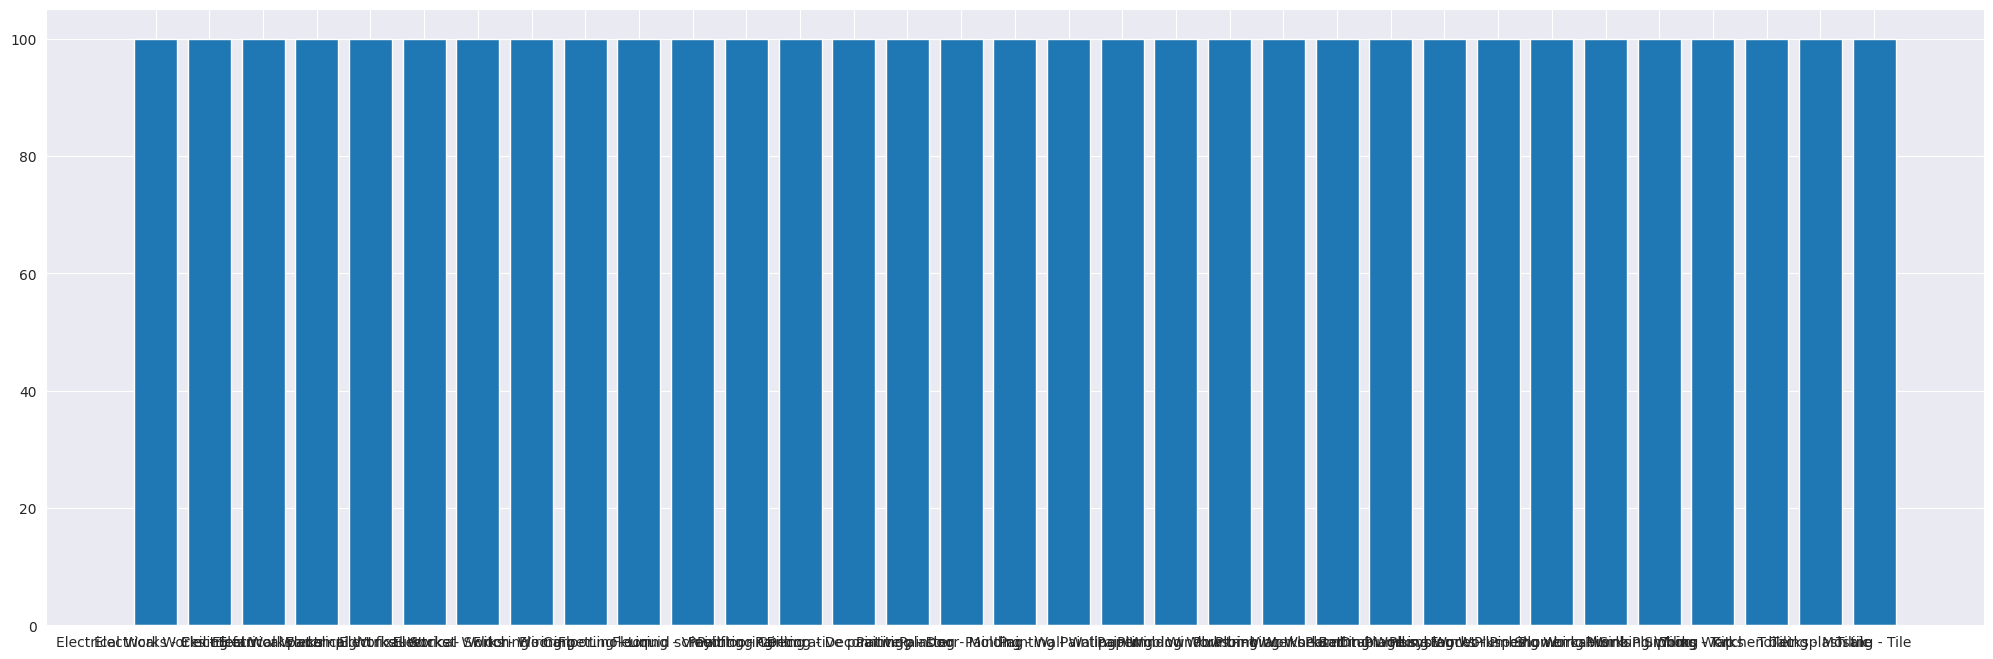

In [ ]:
# Информация о датасете
worker.dataset_info()

In [ ]:
os.listdir("/content/")

['.config', 'цветное_изображение.jpg', 'TRN_33.zip', 'data', 'sample_data']

In [ ]:
from google.colab import files, drive
files.download('/content/цветное_изображение.jpg')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Создание выборок для обучения
img_size=(64, 64)
# img_size=(128, 128)
# img_size=(224, 224)
x_train, x_test, y_train, y_test = worker.create_sets(img_size)

Размер обучающей выборки: (2640, 64, 64, 3)
Размер проверочной выборки: (660, 64, 64, 3)


* max_trials=8
* tuner=None

In [ ]:
clf = ak.ImageClassifier(overwrite=True,                  # перезаписываем проект
                        #  max_trials=3,                    # количество разных моделей Keras
                         max_trials=8,                    # количество разных моделей Keras
                        #  num_classes=8,                   # если None, то оно будет получено из данных.
                         num_classes=None,                   # если None, то оно будет получено из данных.
                         multi_label=False,               # мультиклассовая классификация
                         loss="sparse_categorical_crossentropy", # по умолчанию подбирается в зависимости от количества классов
                         metrics=["accuracy"],            # используется по умолчанию
                         project_name="my_project",       # имя по умолчанию 'image_classifier'
                         directory="my_dir",              # путь для сохранения результатов поиска.
                         seed=16,                         # позволяет воспроизводить результаты обучения на разных машинах
                         max_model_size=None,             # mаксимальное количество скалярных параметров в модели
                         tuner=None,                      # устанавливаем под задачу
                         objective ='val_accuracy')       # метрика модели для минимизации или максимизации


In [ ]:
## Обучаем 3 модели по 10 эпох
# Обучаем 8 моделей по 10 эпох
clf.fit(x_train, y_train,
                  epochs=10,
                  batch_size=64,
                  callbacks=[es_callback, tensorboard_callback],
                  validation_data=(x_test, y_test))

Trial 8 Complete [00h 13m 01s]
val_accuracy: 0.04848484694957733

Best val_accuracy So Far: 0.8833333253860474
Total elapsed time: 03h 25m 49s


In [ ]:
# Получение экземпляра tuner с лучшими гиперпараметрами
tuner = clf.tuner

# Получение таблицы с метриками каждой модели
summary = tuner.results_summary()

# Вывод точностей каждой модели
print(summary)


Results summary
Results in my_dir/my_project
Showing 10 best trials
Trial summary
Hyperparameters:
image_block_1/block_type: efficient
image_block_1/normalize: True
image_block_1/augment: True
image_block_1/image_augmentation_1/horizontal_flip: True
image_block_1/image_augmentation_1/vertical_flip: False
image_block_1/image_augmentation_1/contrast_factor: 0.0
image_block_1/image_augmentation_1/rotation_factor: 0.0
image_block_1/image_augmentation_1/translation_factor: 0.1
image_block_1/image_augmentation_1/zoom_factor: 0.0
image_block_1/efficient_net_block_1/pretrained: True
image_block_1/efficient_net_block_1/version: b7
image_block_1/efficient_net_block_1/trainable: True
image_block_1/efficient_net_block_1/imagenet_size: True
classification_head_1/spatial_reduction_1/reduction_type: global_avg
classification_head_1/dropout: 0
optimizer: adam
learning_rate: 2e-05
Score: 0.9768460392951965
Trial summary
Hyperparameters:
image_block_1/block_type: vanilla
image_block_1/normalize: True
im

In [ ]:
# Получаем лучшие модели:
best_models = clf.tuner.get_best_models(num_models=3)

In [ ]:
best_models[0].summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 cast_to_float32 (CastToFloa  (None, 64, 64, 3)        0         
 t32)                                                            
                                                                 
 normalization (Normalizatio  (None, 64, 64, 3)        7         
 n)                                                              
                                                                 
 random_translation (RandomT  (None, 64, 64, 3)        0         
 ranslation)                                                     
                                                                 
 random_flip (RandomFlip)    (None, 64, 64, 3)         0         
                                                             

In [ ]:
best_models[1].summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 cast_to_float32 (CastToFloa  (None, 64, 64, 3)        0         
 t32)                                                            
                                                                 
 normalization (Normalizatio  (None, 64, 64, 3)        7         
 n)                                                              
                                                                 
 random_translation (RandomT  (None, 64, 64, 3)        0         
 ranslation)                                                     
                                                                 
 random_flip (RandomFlip)    (None, 64, 64, 3)         0         
                                                             

In [ ]:
best_models[2].summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 cast_to_float32 (CastToFloa  (None, 64, 64, 3)        0         
 t32)                                                            
                                                                 
 normalization (Normalizatio  (None, 64, 64, 3)        7         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 64)       0     

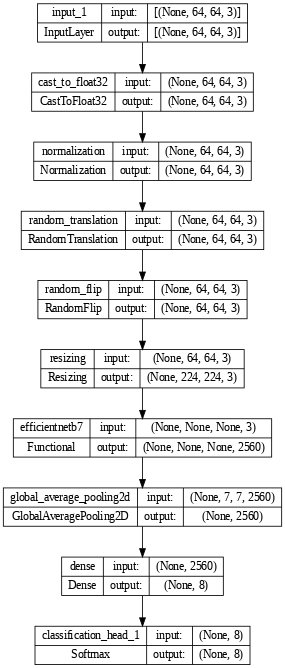

In [ ]:
plot_model(best_models[0],
         to_file='model_plot.png',
         dpi=60,
         show_shapes=True,
         show_layer_names=True)